In [3]:
import os
from os.path import basename, dirname, join
import sys
import glob 

import numpy as np
import numpy.ma as ma
import scipy.stats as stats
import pandas as pd
from scipy.optimize import minimize

from datetime import datetime
from datetime import timedelta
from time import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as lines

# from pandas.tseries import converter

In [4]:

## Set up directory referencing
# Package data
git_dir = os.getcwd()
while basename(git_dir) != 'CosumnesRiverRecharge':
    git_dir = dirname(git_dir)
usr_dir = os.getcwd()
while basename(usr_dir) != 'Users':
    temp = basename(usr_dir)
    usr_dir = dirname(usr_dir)
usr_dir = join(usr_dir, temp)
gwfm_dir = join(usr_dir, 'Box/research_cosumnes/GWFlowModel')
# print(git_dir, gwfm_dir)
gwfm_dir

'C:\\Users\\ajcalder\\Box/research_cosumnes/GWFlowModel'

In [5]:
# set box directory for output figures and data
box_dir = gwfm_dir+'/Levee_setback/levee_setback_distance_analysis/'

# tprogs_id = '' # original tprogs with conditioning data in output tsim
tprogs_id = '_no_conditioning'

data_dir = box_dir+ tprogs_id+'/data_output/'
fig_dir = box_dir+tprogs_id+'/figures/'

chan_dir = box_dir+'channel_data/'
gis_dir = chan_dir+'GIS/'

In [6]:
fxn_dir = git_dir+'/python_utilities'
if fxn_dir not in sys.path:
    sys.path.append(fxn_dir)
# sys.path
# import muskingum_recharge as mr

from importlib import reload
# reload(mr)

# Local model Connec3D example

In [58]:
c3d_dir = join(box_dir, 'connec3d_local_results')
os.listdir(c3d_dir)

['CCO_85.txt',
 'R11newww.dat',
 'R11_18.CCO',
 'R11_18.COF',
 'R11_18.STA',
 'R11_6.CCO',
 'R11_6.COF',
 'R11_6.PAR',
 'R11_6.STA',
 'Viability_Recharge_Projects_Alluvial_review_9.docx']

In [14]:
# x,y, z
nrow, ncol, nlay = 105, 60, 200

In [67]:
# z, y,x is the shape that produces appropriate volumes
arr_shape = (nlay,ncol,nrow)
dat_in = np.loadtxt(join(c3d_dir, 'R11newww.dat'))


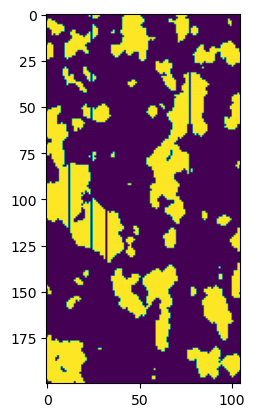

In [81]:
# z, y, x ordering
dat = np.reshape(dat_in, (nlay,ncol,nrow))

plt.imshow(dat[:,30,:])
# plt.imshow(dat[:,:,50])
# almost looks like the location of wells was clipped

In [68]:
cco_18_in = np.loadtxt(join(c3d_dir, 'R11_18.CCO'))
cco_6_in = np.loadtxt(join(c3d_dir, 'R11_6.CCO'))
# reshape to array format
cco_18 = np.reshape(cco_18_in, arr_shape)
cco_6 = np.reshape(cco_6_in, arr_shape)

In [56]:
def cco_review(cco_in, name):
    print('For ',name,' pt %.2f %% are connected' %(100*np.sum(cco_in!=0)/ cco_in.shape[0]))
    n = np.unique(cco_in).shape[0]

    cnt = np.histogram(cco_in, bins = np.arange(1, n+1)-0.5)
    np.argmax(cnt[0])
    print('Largest ', name, ' pt body is %.2f %% of volume' %(100*np.max(cnt[0])/cco_in.shape[0]))

cco_review(cco_18_in, '18')
cco_review(cco_6_in, '6')

For  18  pt 22.87 % are connected
Largest  18  pt body is 21.62 % of volume
For  6  pt 22.87 % are connected
Largest  6  pt body is 8.72 % of volume


Text(0.5, 1.0, '6 pt')

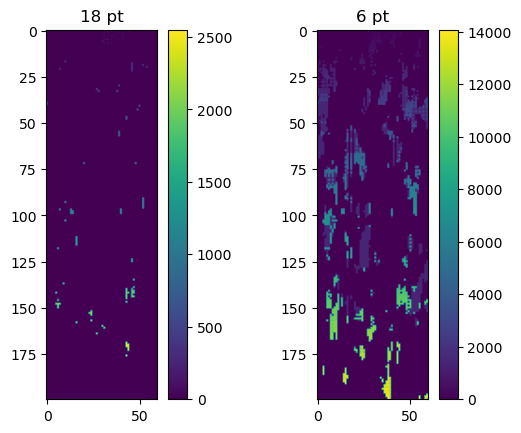

In [80]:
k = 50
fig,ax =plt.subplots(1,2)
im = ax[0].imshow(cco_18[:,:,k])
plt.colorbar(im)
ax[0].set_title('18 pt')
# plt.show()

im = ax[1].imshow(cco_6[:,:,k])
plt.colorbar(im)
ax[1].set_title('6 pt')


# Regional Model Connec3D input

In [ ]:
# np.reshape fortran- F = first index is fastest, last is slowest, C = last is fastest, first is slowest
# CONNEC3D assumes Z is fastest then Y then X

In [85]:

tprogs_id = '_no_conditioning'
mf_tprogs_dir = gwfm_dir+'/UPW_data/tprogs_final' + tprogs_id+'/'
tprogs_files = glob.glob(mf_tprogs_dir+'*')
# tprogs_files

In [136]:
# z, y, x
nlay, nrow, ncol = (320, 100,230)
arr_dim = (nlay,nrow,ncol)

In [98]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'

if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 

loadpth = loadpth +'/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/'
model_ws = loadpth+'Connec3d' + tprogs_id
os.makedirs(model_ws, exist_ok=True)

In [ ]:
# a basic connectivity run takes about 1 hour (7610 components), good enough in parallel with python
# might be worth trying to compile with ifortran to speed things up
# adding a compiler option seemed to speed things up
# reviewing CCO output showed a bad result (didn't line up with input) reshape order='F' is not needed

In [153]:
# write dat file input
for t in np.arange(0,1):
    tprogs_line = np.loadtxt(tprogs_files[t])
    # convert any negatives representing input data to same value
    tprogs_arr = np.abs(np.reshape(tprogs_line, (320, 100,230)))
    conn_arr = np.zeros((320, 100,230))
    # new array where sand, gravel (1,2) are 1-coarse and sandy mud, mud are 0-fine
    conn_arr[(tprogs_arr == 1)|(tprogs_arr == 2)] = 1
    # convert to z,y, x order
    conn_line = np.reshape(conn_arr, (320*100*230) ) #, order='F')

    dat_nam = 'r'+str(t).zfill(3)+'.DAT'
    np.savetxt(join(model_ws,  dat_nam), conn_line.astype(int))

In [128]:
# write par file input
for t in np.arange(0,100):
    dat_nam = 'r'+str(t).zfill(3)+'.DAT'
    connec_id = 1
    connec_pts = 6 # 6, 18, 26 point connectivity (faces, edge, corners)
    # dat file name
    # number of cells in x,y,z
    # x,y,z cell lengths
    # lags, Alisha recommended 30
    out_par = [str(connec_id),str(connec_pts), dat_nam, '230 100 320', '200 200 0.5', '30']
    out_par = '\n'.join(out_par) +'\n'

    with open(model_ws+ '/r'+str(t).zfill(3)+'.PAR', 'w') as f:
        f.write(out_par)
        # output file names
        f.write('r'+str(t).zfill(3)+'.STA\n')
        f.write('r'+str(t).zfill(3)+'.CCO\n')
        f.write('r'+str(t).zfill(3)+'.COF\n')



In [133]:
# write batch file input
with open(model_ws+ '/00_run_all_series.bat', 'w') as f:
    for t in np.arange(0,100):
        file = 'r'+str(t).zfill(3)+'.PAR'
        runline = 'echo '+ file +' | Connec3DLarge.exe\n'
        f.write(runline) 


## Check output

In [138]:
t = 0
tprogs_line = np.loadtxt(tprogs_files[t])
# convert any negatives representing input data to same value
tprogs_arr = np.abs(np.reshape(tprogs_line, (320, 100,230)))
conn_arr = np.zeros((320, 100,230))
# new array where sand, gravel (1,2) are 1-coarse and sandy mud, mud are 0-fine
conn_arr[(tprogs_arr == 1)|(tprogs_arr == 2)] = 1

In [137]:
cco_in = np.loadtxt(join(model_ws, 'r000.CCO'))
# reshape to array format
cco = np.reshape(cco_in, arr_dim)

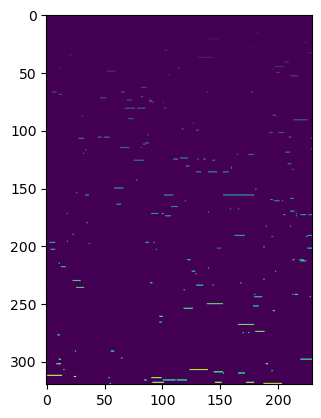

In [147]:
plt.imshow(cco[:,50,:])

In [152]:
(cco>=1).sum(), ((cco>=1)*(conn_arr==1)).sum()



(1903973, 494128)

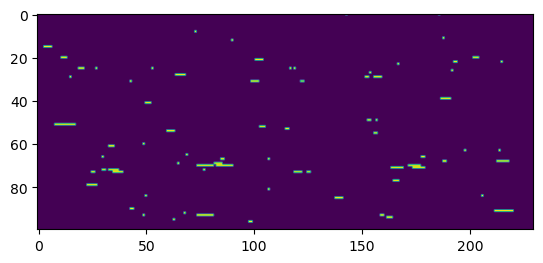

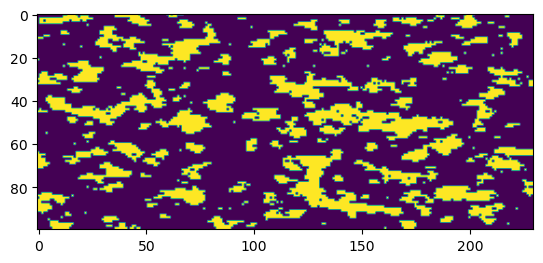

In [145]:
cco.shape
k = 200
plt.imshow(cco[k,:])
plt.show()

plt.imshow(conn_arr[k,:])
plt.show()